# Emojify

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/luisangelmendozavelasco.github.io/blob/master/_portfolio/Deep_Learning_Specialization/portfolio-10.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

**Objective**: Build a [Long Short-Term Memory (LSTM)](https://en.wikipedia.org/wiki/Long_short-term_memory) model that takes word embeddings as input to predict the most appropriate emoji.

## Import libraries

In [1]:
import numpy as np
from keras import layers, Model
import pandas as pd
import emoji
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

2024-08-14 11:16:50.392535: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 11:16:50.419276: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 11:16:50.427429: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-14 11:16:50.478885: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Download the data

In [2]:
%%bash

wget -q https://raw.githubusercontent.com/LuisAngelMendozaVelasco/Deep_Learning_Specialization/main/Sequence_Models/Week2/Labs/data/tesss.csv
wget -q https://raw.githubusercontent.com/LuisAngelMendozaVelasco/Deep_Learning_Specialization/main/Sequence_Models/Week2/Labs/data/train_emoji.csv
gdown -q 1UBn4ibWdLH4wNRbCTodim7IFHGnNrDvt
gunzip ./glove.6B.50d.txt.gz

## Load the data

In [3]:
train_data = pd.read_csv('./train_emoji.csv', header=None)
test_data = pd.read_csv('./tesss.csv', header=None)

X_train, Y_train = train_data[0].to_numpy(), train_data[1].to_numpy()
X_test, Y_test = test_data[0].to_numpy(), test_data[1].to_numpy()

max_len = len(max(X_train, key=len).split())
print(f'Maximum number of words in a sentence: {max_len}')

Maximum number of words in a sentence: 10


In [4]:
def label_to_emoji(label):
    """
    Converts a label (int or string) into the corresponding emoji code (string) ready to be printed
    """
    
    emoji_dictionary = {"0": ":heart:",
                        "1": ":baseball:",
                        "2": ":smile:",
                        "3": ":disappointed:",
                        "4": ":fork_and_knife:"}

    return emoji.emojize(emoji_dictionary[str(label)], language='alias')

In [5]:
for idx in range(10):
    print(X_train[idx], label_to_emoji(Y_train[idx]))

never talk to me again 😞
I am proud of your achievements 😄
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴
I love you mum ❤️
Stop saying bullshit 😞
congratulations on your acceptance 😄
The assignment is too long  😞
I want to go play ⚾


The model will use pre-trained [word embeddings](https://en.wikipedia.org/wiki/Word_embedding) to represent words. It will use pre-trained 50-dimensional [GloVe embeddings](https://nlp.stanford.edu/projects/glove/) to load the word vector representations.

In [6]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding='utf-8') as f:
        words = set()
        word_to_vec_map = {}

        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}

        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1

    return words_to_index, index_to_words, word_to_vec_map

In [7]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('./glove.6B.50d.txt')

## Create a function to convert sentences into a list of indices

Most deep learning frameworks require that all sequences in the same batch have the same length. The common solution to handling sequences of different length is to use padding. 

Specifically:

- Set a maximum sequence length
- Pad all sequences to have the same length.

In [8]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to 'keras.layers.Embedding()'.
    
    Arguments:
    X -- Array of sentences (strings), of shape (m, 1)
    word_to_index -- A dictionary containing the each word mapped to its index
    max_len -- Maximum number of words in a sentence. We can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- Array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0] # Number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape
    X_indices = np.zeros((len(X), max_len))
    
    for i in range(m): # Loop over training examples
        # Convert the i-th training sentence in lower case and split it into words
        sentence_words = [w.lower() for w in X[i].split()]
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # If w exists in the dictionary
            if w in word_to_index:
                # Set the (i, j)-th entry of X_indices to the index of the correct word
                X_indices[i, j] = word_to_index[w]
                # Increment j to j + 1
                j = j + 1
    
    return X_indices

## Create a function to load a pretrained embedding layer

In Keras, the embedding matrix is represented as a "layer".

- The embedding matrix maps word indices to embedding vectors.
    - The word indices are positive integers.
    - The embedding vectors are dense vectors of fixed size.
    - A "dense" vector is the opposite of a sparse vector. It means that most of its values are non-zero.
- The embedding matrix can be derived in two ways:
    - Training a model to derive the embeddings from scratch.
    - Using a pretrained embedding.

In [9]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- Dictionary mapping words to their GloVe vector representation
    word_to_index -- Dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- Pretrained layer Keras instance
    """
    
    vocab_size = len(word_to_index) + 1             # Adding 1 to fit Keras embedding (requirement)
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]    # Define dimensionality of your GloVe word vectors (= 50)

    # Step 1
    # Initialize the embedding matrix as a numpy array of zeros.
    embedding_matrix = np.zeros((vocab_size, emb_dim))

    # Step 2
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary.
    for word, idx in word_to_index.items():
        embedding_matrix[idx, :] = word_to_vec_map[word]
    
    # Step 3
    # Define Keras embedding layer with the correct input and output sizes.
    # Make it non-trainable.
    embedding_layer = layers.Embedding(vocab_size, emb_dim, trainable=False)

    # Step 4
    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,))

    # Set the weights of the embedding layer to the embedding matrix. The layer is now pretrained.
    embedding_layer.set_weights([embedding_matrix])

    return embedding_layer

## Create the model

In [10]:
# Define sentence_indices as the input.
sentence_indices = layers.Input((max_len,), dtype='int32')

# Create the embedding layer pretrained with GloVe Vectors.
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)

# Propagate sentence_indices through the embedding layer.
embeddings = embedding_layer(sentence_indices)    

# Propagate the embeddings through an LSTM layer with 128-dimensional hidden state.
# The returned output should be a batch of sequences.
x = layers.LSTM(128, return_sequences=True)(embeddings)
# Add dropout with a probability of 0.5
x = layers.Dropout(0.5)(x) 
# Propagate x trough another LSTM layer with 128-dimensional hidden state.
# The returned output should be a single hidden state, not a batch of sequences.
x = layers.LSTM(128)(x)
# Add dropout with a probability of 0.5
x = layers.Dropout(0.5)(x) 
# Propagate x through a Dense layer with 5 units.
x = layers.Dense(5)(x)
# Add a softmax activation.
outputs = layers.Activation('softmax')(x)

# Create Model instance which converts sentence_indices into outputs.
model = Model(inputs=sentence_indices, outputs=outputs)

2024-08-14 11:17:17.242591: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2127 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 10, 50)         │    20,000,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 128)        │        91,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           645 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,223,927 (77.15 MB)

 Trainable params: 223,877 (874.52 KB)

 Non-trainable params: 20,000,050 (76.29 MB)

## Compile the model

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Fit the model

In [13]:
X_train_indices = sentences_to_indices(X_train, word_to_index, max_len)
Y_train_oh = tf.one_hot(Y_train, depth=5)

print(f'{X_train[0]} --> {X_train_indices[0, :]}')
print(f'{Y_train[0]} --> {Y_train_oh[0]}')

never talk to me again --> [259914. 352214. 360915. 239105.  47887.      0.      0.      0.      0.
      0.]
3 --> [0. 0. 0. 1. 0.]


In [14]:
history = model.fit(X_train_indices, Y_train_oh, epochs=50, batch_size=32, shuffle=True, verbose=0)

2024-08-14 11:17:21.951862: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


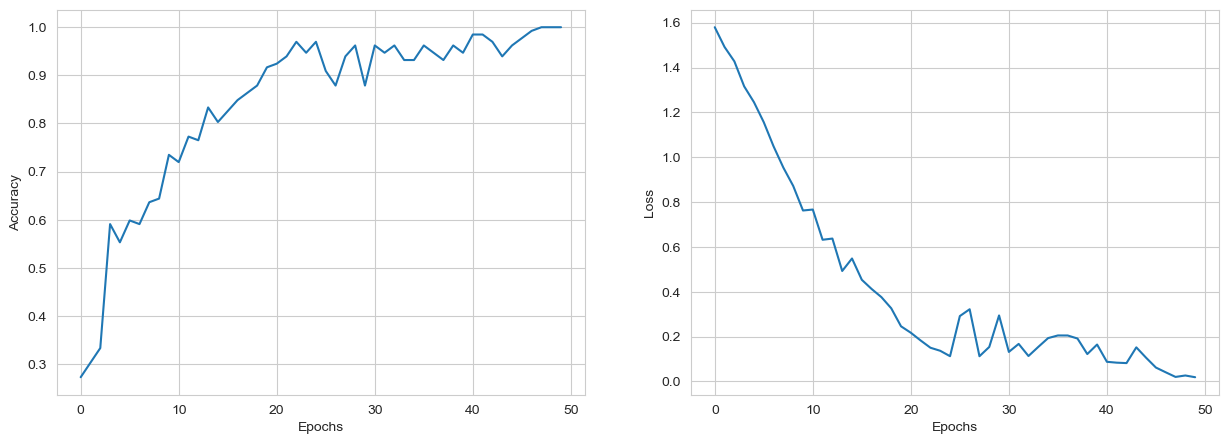

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history.history['accuracy'])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")

ax2.plot(history.history['loss'])
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")

plt.show()

## Evaluate the model

In [16]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len=max_len)
Y_test_oh = tf.one_hot(Y_test, depth=5)
loss, accuracy = model.evaluate(X_test_indices, Y_test_oh, verbose=0)

print("Test accuracy =", accuracy)
print("Test loss =", loss)

Test accuracy = 0.8571428656578064
Test loss = 0.43211302161216736


Show the mislabelled examples.

In [19]:
prediction = model.predict(X_test_indices, verbose=0)

for i in range(len(X_test)):
    num = np.argmax(prediction[i])
    
    if(num != Y_test[i]):
        print("Sentence: " + X_test[i] + " -> Expected emoji: " + label_to_emoji(Y_test[i]) + ", Prediction: " + label_to_emoji(num))

Sentence: work is hard	 -> Expected emoji: 😞, Prediction: 😄
Sentence: This girl is messing with me	 -> Expected emoji: 😞, Prediction: ❤️
Sentence: you brighten my day	 -> Expected emoji: 😄, Prediction: ❤️
Sentence: she is a bully	 -> Expected emoji: 😞, Prediction: 😄
Sentence: My life is so boring	 -> Expected emoji: 😞, Prediction: ❤️
Sentence: will you be my valentine	 -> Expected emoji: 😄, Prediction: ❤️
Sentence: go away	 -> Expected emoji: 😞, Prediction: ⚾
Sentence: yesterday we lost again	 -> Expected emoji: 😞, Prediction: ⚾


In [18]:
!rm *.csv *.txt